In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from sklearn.metrics import roc_auc_score
import warnings

warnings.simplefilter('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(460),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(460),
        transforms.CenterCrop(430),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(460),
        transforms.CenterCrop(430),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/mehmu/Desktop/PyProjects/Projects/github repo/BreastCancer/Second Dataset/output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                            shuffle=True, num_workers=4)
                    for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes


In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,40))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

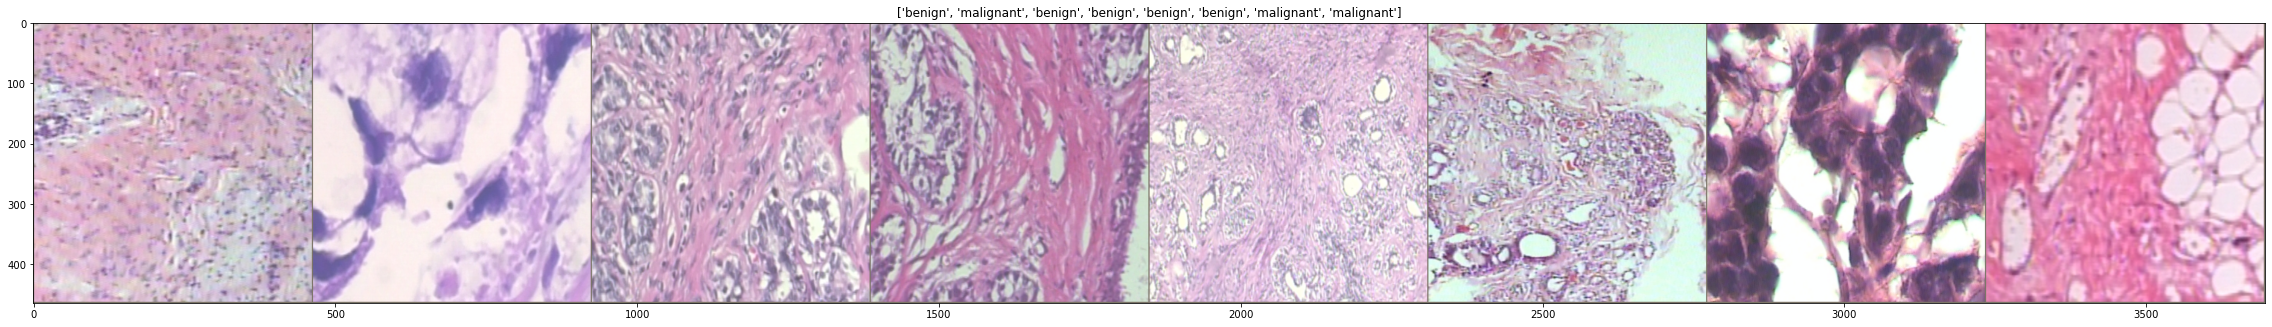

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_auc=0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    
                    #auc=roc_auc_score(outputs.cpu().max(1)[1],labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #running_auc +=auc.item() * inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            #epoch_auc = running_auc / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f}, epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f} '.format(        
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3940 Acc: 0.8340 
val Loss: 0.1574 Acc: 0.9374 

Epoch 1/24
----------
train Loss: 0.2780 Acc: 0.8902 
val Loss: 0.1987 Acc: 0.9228 

Epoch 2/24
----------
train Loss: 0.2563 Acc: 0.8967 
val Loss: 0.1559 Acc: 0.9365 

Epoch 3/24
----------
train Loss: 0.2430 Acc: 0.9018 
val Loss: 0.2835 Acc: 0.8894 

Epoch 4/24
----------
train Loss: 0.2135 Acc: 0.9164 
val Loss: 0.1938 Acc: 0.9305 

Epoch 5/24
----------
train Loss: 0.2012 Acc: 0.9224 
val Loss: 0.0861 Acc: 0.9700 

Epoch 6/24
----------
train Loss: 0.1804 Acc: 0.9308 
val Loss: 0.1118 Acc: 0.9614 

Epoch 7/24
----------
train Loss: 0.1303 Acc: 0.9553 
val Loss: 0.0685 Acc: 0.9794 

Epoch 8/24
----------
train Loss: 0.1235 Acc: 0.9608 
val Loss: 0.0631 Acc: 0.9768 

Epoch 9/24
----------
train Loss: 0.1071 Acc: 0.9592 
val Loss: 0.0708 Acc: 0.9777 

Epoch 10/24
----------
train Loss: 0.1162 Acc: 0.9577 
val Loss: 0.0630 Acc: 0.9828 

Epoch 11/24
----------
train Loss: 0.1080 Acc: 0.9620 
val Loss:

In [9]:
torch.save(model_ft, 'bcancer_model_460p_30epoch-0.987acc.h5')

In [5]:
model_ft=torch.load('bcancer_model_30epoch-0.9699acc.h5')

In [5]:
inputs.size()

torch.Size([64, 3, 50, 50])

In [7]:
model_ft.eval()
pred=model_ft(inputs.to(device)).max(1)[1]


In [13]:
pred.cpu()

tensor([1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score

df=pd.DataFrame(columns=['f1','accuracy_score','recall_score','AUC'])

for _ in range(30):
    inputs, classes = next(iter(dataloaders['test']))
    model_ft.eval()
    pred=model_ft(inputs.to(device)).max(1)[1]
    f=f1_score(pred.cpu(),classes)
    a=accuracy_score(pred.cpu(),classes)
    r=recall_score(pred.cpu(),classes)
    try:
        auc=roc_auc_score(pred.cpu(),classes)
    except:
        auc='Error'
    df.loc[len(df.index)]=[f,a,r,auc]

df

,f1,accuracy_score,recall_score,AUC
0,1.000000,1.000,1.000000,1.000000
1,1.000000,1.000,1.000000,1.000000
2,1.000000,1.000,1.000000,1.000000
3,1.000000,1.000,1.000000,1.000000
4,1.000000,1.000,1.000000,1.000000
5,1.000000,1.000,1.000000,1.000000
6,1.000000,1.000,1.000000,1.000000
7,1.000000,1.000,1.000000,1.000000
8,0.888889,0.875,0.800000,0.900000
9,1.000000,1.000,1.000000,1.000000


In [15]:
print('f1: ', df.f1.mean())
print('accuracy_score: ', df.accuracy_score.mean())
print('recall: ', df.recall_score.mean())
print('AUC: ', df.AUC.mean())

f1:  0.9796477596477596
accuracy_score:  0.9708333333333333
recall:  0.9771428571428572
AUC:  0.958015873015873


In [16]:
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score

df=pd.DataFrame(columns=['f1','accuracy_score','recall_score','AUC'])

for _ in range(20):
    for i in ['test','train']:
        inputs, classes = next(iter(dataloaders[i]))
        model_ft.eval()
        pred=model_ft(inputs.to(device)).max(1)[1]
        f=f1_score(pred.cpu(),classes)
        a=accuracy_score(pred.cpu(),classes)
        r=recall_score(pred.cpu(),classes)
        try:
            auc=roc_auc_score(pred.cpu(),classes)
        except:
            auc='Error'
        df.loc[len(df.index)]=[f,a,r,auc]

df

,f1,accuracy_score,recall_score,AUC
0,1.000000,1.000,1.000000,1.000000
1,1.000000,1.000,1.000000,1.000000
2,1.000000,1.000,1.000000,1.000000
3,1.000000,1.000,1.000000,1.000000
4,1.000000,1.000,1.000000,1.000000
5,1.000000,1.000,1.000000,1.000000
6,1.000000,1.000,1.000000,1.000000
7,1.000000,1.000,1.000000,1.000000
8,0.857143,0.875,1.000000,0.900000
9,1.000000,1.000,1.000000,1.000000


In [17]:
print('f1: ', df.f1.mean())
print('accuracy_score: ', df.accuracy_score.mean())
print('recall: ', df.recall_score.mean())
print('AUC: ', df.AUC.mean())

f1:  0.9878066378066379
accuracy_score:  0.9875
recall:  0.9908333333333335
AUC:  0.9904166666666667
